# Importance of XCov term in loss function
- How does the model behave differently without XCov?
- Does amount of input variation matter? (None,Med,hi)?

In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src.data_loader import Shifted_Data_Loader
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import GResNet,EDense
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from keras.datasets import fashion_mnist,mnist
from keras.layers import Dense
# from tabulate import tabulate

Using TensorFlow backend.


In [2]:
config,_ = get_config()
# Boilerplate
setattr(config, 'proj_root', '/home/elijahc/projects/vae')
setattr(config, 'log_dir', '/home/elijahc/projects/vae/logs')
setattr(config, 'dev_mode',False)
setattr(config,'model_dir','/home/elijahc/projects/vae/models/2019-03-26/')
setattr(config, 'seed', 7)
setattr(config, 'project','vae')

# Architecture Params
setattr(config, 'enc_layers', [3000,2000])
setattr(config, 'dec_blocks', [4,2,1])
setattr(config, 'z_dim', 25)
setattr(config, 'y_dim', 10)

# Training Params
setattr(config, 'batch_size', 512)
setattr(config, 'dataset', 'fashion_mnist')
setattr(config, 'epochs', 60)
setattr(config, 'monitor', 'val_G_loss')
setattr(config, 'min_delta', 0.5)
setattr(config, 'optimizer', 'adam')

# Loss Weights
setattr(config, 'xcov', 0)
setattr(config, 'recon', 25)
setattr(config, 'xent', 15)

In [3]:
if not config.dev_mode:
    print('setting up...')
    prepare_dirs_and_logger(config)
    
vars(config)
np.random.seed(7)

setting up...
/home/elijahc/projects/vae/logs/0326_134419_fashion_mnist  does not exist...
creating...


In [4]:
translation_amt = 0.8 # Med
DL = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
                         translation=translation_amt,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.8
rot_max:  None
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...


In [5]:
G_builder = GResNet(y_dim=config.y_dim,z_dim=config.z_dim,dec_blocks=config.dec_blocks)
E_builder = EDense(enc_layers=config.enc_layers,z_dim=config.z_dim,)
trainer = Trainer(config,DL,E_builder,G_builder,)
# setattr(trainer.config,'model_dir','/home/elijahc/projects/vae/models/2019-01-22/')

building encoder...
building decoder/generator...


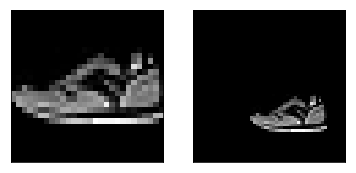

In [6]:
pt,idx = plot_ovt(DL,cmap='gray')

In [7]:
trainer.model

In [8]:
import keras.backend as K
K.int_shape(trainer.model.outputs[0])

(None, 3136)

In [9]:
# trainer.build_model()
trainer.compile_model()
# trainer.G.summary()

In [10]:
from keras.layers import Concatenate,Input

In [11]:
G_input = Input(shape=(trainer.config.y_dim+trainer.config.z_dim,))
trainer.Gbuilder(G_input)

<tf.Tensor 'G_image_flat_1/Reshape:0' shape=(?, ?) dtype=float32>

In [12]:
im_input = trainer.input
gen_im = trainer.model.output[0]
latent_vec = Concatenate()([trainer.y_class,trainer.z_lat])

In [13]:
im_stack = Concatenate()([im_input,gen_im])

In [14]:
print(im_input)
print(gen_im)

Tensor("input_image:0", shape=(?, 3136), dtype=float32)
Tensor("G/G_image_flat/Reshape:0", shape=(?, ?), dtype=float32)


In [15]:
trainer.model.output

[<tf.Tensor 'G/G_image_flat/Reshape:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'class/Softmax:0' shape=(?, 10) dtype=float32>]

In [16]:
# trainer.G.summary()
G_out = trainer.G.get_layer('G_image_flat')
trainer.E.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3000)         9411000     input_image[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2000)         6002000     dense_1[0][0]                    
__________________________________________________________________________________________________
enc_merge (Dense)               (None, 36)           72036       dense_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [17]:
from keras.utils import to_categorical
RF = to_categorical(np.ones(len(DL.sx_train)),num_classes=2)

In [18]:
trainer.go(x=DL.sx_train,
           y={
               'class':DL.y_train_oh,
#                'D_real':RF,
               'G':DL.sx_train},
           validation_split=0.05,
           verbose=0)

Epoch        G_loss      val_G_loss  val_class_acc
0:           195.8106    68.3649     0.276       
1:           53.4892     49.5679     0.4593      
2:           43.0019     45.3951     0.5243      
3:           36.2186     47.3423     0.5947      
4:           31.7289     40.5363     0.62        
5:           29.4793     35.7627     0.6457      
6:           27.8063     30.2962     0.6687      
7:           25.7851     29.2911     0.69        
8:           23.9323     25.0416     0.696       
9:           22.7907     24.019      0.6937      
10:          22.0758     21.7116     0.717       
11:          20.9701     21.0376     0.7217      
12:          20.2147     20.1134     0.7157      
13:          19.234      19.5089     0.732       
14:          18.6804     20.0102     0.734       
15:          18.3862     20.8292     0.735       
16:          19.1469     18.13       0.7477      
17:          17.4957     17.6984     0.749       
18:          17.0359     17.2807     0.75        

In [19]:
hist_df = pd.DataFrame.from_records(trainer.model.history.history)
hist_df.head()

,G_loss,G_mse,class_acc,class_loss,loss,val_G_loss,val_G_mse,val_class_acc,val_class_loss,val_loss
0,195.810612,195.810612,0.152544,2.461525,4932.197676,68.364898,68.364898,0.276000,1.940538,1738.240067
1,53.489164,53.489164,0.377158,1.641136,1361.855674,49.567870,49.567870,0.459333,1.414630,1260.425751
2,43.001916,43.001916,0.499772,1.316938,1094.811461,45.395101,45.395101,0.524333,1.221794,1153.213980
3,36.218611,36.218611,0.560895,1.145877,922.662846,47.342291,47.342291,0.594667,1.046953,1199.271138
4,31.728879,31.728879,0.604912,1.039218,808.819696,40.536316,40.536316,0.620000,0.964952,1027.891673


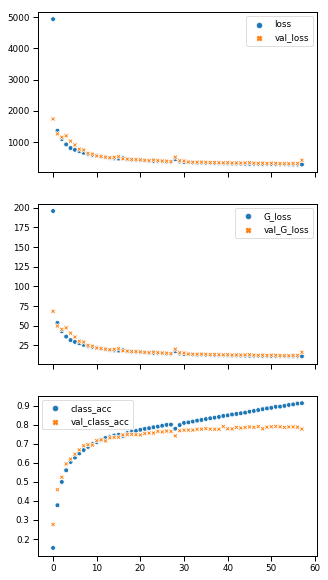

In [20]:
sns.set_context('paper')
metrics = ['loss','G_loss','class_acc']
fig,axs = plt.subplots(nrows=len(metrics),sharex=True,figsize=(5,10))
for metric_name,ax in zip(metrics,axs):
    sns.scatterplot(data=hist_df[[metric_name,'val_'+metric_name]],ax=ax)

In [21]:
import datetime as dt
def clean_config(config,keys=['dev_mode','log_dir','log_level','proj_root']):
    c = vars(config)
    for k in keys:
        if k in c.keys():
            del c[k]
    
    c['uploaded_by']='elijahc'
    c['last_updated']= str(dt.datetime.now())
    return c

In [22]:
run_meta = clean_config(config)
run_meta['project']='vae'
run_meta['ecc_max']=0.8
run_meta

{'batch_size': 512,
 'dataset': 'fashion_mnist',
 'dec_blocks': [4, 2, 1],
 'ecc_max': 0.8,
 'enc_layers': [3000, 2000],
 'epochs': 60,
 'last_updated': '2019-03-26 13:51:19.236278',
 'min_delta': 0.5,
 'model_dir': '/home/elijahc/projects/vae/models/2019-03-26/',
 'model_name': '0326_134419_fashion_mnist',
 'monitor': 'val_G_loss',
 'optimizer': 'adam',
 'project': 'vae',
 'recon': 25,
 'run_dir': '/home/elijahc/projects/vae/logs/0326_134419_fashion_mnist',
 'seed': 7,
 'uploaded_by': 'elijahc',
 'xcov': 0,
 'xent': 15,
 'y_dim': 10,
 'z_dim': 25}

In [23]:
trainer.save_model()
run_conf = clean_config(config)

with open(os.path.join(run_conf['model_dir'],'config.json'), 'w') as fp:
    json.dump(run_conf, fp)

hist_df.to_parquet(os.path.join(run_conf['model_dir'],'train_history.parquet'))

In [24]:
from keras.models import Model
from keras.layers import Input

In [25]:
generator = trainer.G

In [26]:
trainer.E.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3000)         9411000     input_image[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2000)         6002000     dense_1[0][0]                    
__________________________________________________________________________________________________
enc_merge (Dense)               (None, 36)           72036       dense_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [27]:
trainer.model.get_layer(name='dense_1').output

<tf.Tensor 'dense_1/Relu:0' shape=(?, 3000) dtype=float32>

In [28]:
z_encoder = Model(trainer.input,trainer.z_lat)
classifier = Model(trainer.input,trainer.y_class)

l1_encoder = Model(trainer.input,trainer.model.get_layer(name='dense_1').output)
l2_encoder = Model(trainer.input,trainer.model.get_layer(name='dense_2').output)

In [29]:
z_w_k = K.get_value(z_encoder.get_layer('enc_merge').weights[0])[:,10:-1]

(array([  3.,   2.,   4.,   4.,  30., 117., 184., 184., 196., 175., 179.,
        174., 191., 160., 172., 142.,  58.,  10.,   8.,   3.,   1.,   0.,
          0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([-0.10301483, -0.09325987, -0.0835049 , -0.07374994, -0.06399497,
        -0.05424   , -0.04448504, -0.03473007, -0.02497511, -0.01522014,
        -0.00546517,  0.00428979,  0.01404476,  0.02379972,  0.03355469,
         0.04330966,  0.05306462,  0.06281959,  0.07257456,  0.08232952,
         0.09208449,  0.10183945,  0.11159442,  0.12134939,  0.13110435,
         0.14085932,  0.15061429,  0.16036925,  0.17012422,  0.17987919,
         0.18963414,  0.19938911], dtype=float32),
 <a list of 31 Patch objects>)

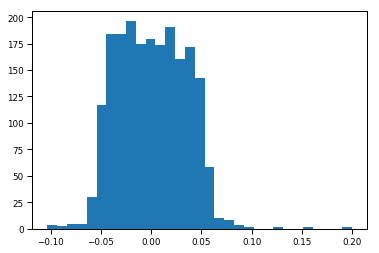

In [30]:
plt.hist(z_w_k[:,7],bins=31)

(array([2.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 1.000e+01, 1.500e+01,
        4.500e+01, 1.150e+02, 3.170e+02, 1.720e+03, 5.853e+03, 7.153e+03,
        7.233e+03, 7.508e+03, 7.243e+03, 6.894e+03, 4.566e+03, 8.850e+02,
        2.600e+02, 8.100e+01, 4.900e+01, 2.100e+01, 1.200e+01, 6.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00]),
 array([-0.21210517, -0.19617163, -0.18023808, -0.16430454, -0.14837101,
        -0.13243747, -0.11650392, -0.10057038, -0.08463684, -0.0687033 ,
        -0.05276976, -0.03683622, -0.02090268, -0.00496914,  0.0109644 ,
         0.02689795,  0.04283149,  0.05876503,  0.07469857,  0.09063211,
         0.10656565,  0.12249919,  0.13843273,  0.15436627,  0.17029981,
         0.18623336,  0.2021669 ,  0.21810044,  0.23403397,  0.24996752,
         0.26590106,  0.2818346 ], dtype=float32),
 <a list of 31 Patch objects>)

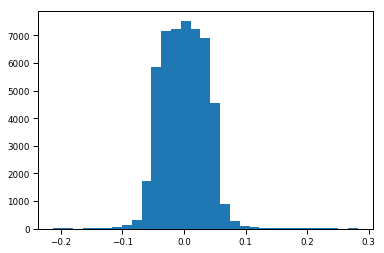

In [31]:
plt.hist(z_w_k.flatten(),bins=31)

In [32]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3000)              9411000   
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              6002000   
_________________________________________________________________
enc_merge (Dense)            (None, 36)                72036     
_________________________________________________________________
lambda_1 (Lambda)            [(None, 10), (None, 25),  0         
_________________________________________________________________
class (Activation)           (None, 10)                0         
Total params: 15,485,036
Trainable params: 15,485,036
Non-trainable params: 0
________________________________________________________________

In [33]:
DL.y_test_oh.shape

(10000, 10)

In [34]:
classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
classifier.evaluate(DL.sx_test,DL.y_test_oh,batch_size=config.batch_size)

10000/10000 [==============================] - 0s 35us/step


[0.627907670211792, 0.7779000001907349]

In [35]:
z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
l1_enc = l1_encoder.predict(DL.sx_test,batch_size=config.batch_size)
l2_enc = l2_encoder.predict(DL.sx_test,batch_size=config.batch_size)
# y_lat = y_lat_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_lat = classifier.predict(DL.sx_test,batch_size=config.batch_size)

In [36]:
l2_enc.shape

(10000, 2000)

In [37]:
_lat_vec = np.concatenate([y_lat,z_enc],axis=1)
_lat_vec.shape

(10000, 35)

In [38]:
z_enc_mu = np.mean(z_enc,axis=0)
z_enc_cov = np.cov(z_enc,rowvar=False)

In [39]:
np.random.multivariate_normal(z_enc_mu,z_enc_cov,size=50).shape

(50, 25)

In [40]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

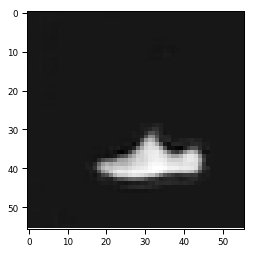

In [41]:
rand_im = np.random.randint(0,10000)
plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [42]:
_lat_vec[rand_im]

array([ 9.2261879e-11,  2.5154968e-18,  3.1348725e-13,  2.6316584e-09,
        2.4857499e-10,  6.5719199e-05,  3.2122163e-12,  9.9985683e-01,
        2.5790454e-05,  5.1682764e-05, -1.3952005e-01,  2.0015969e+00,
       -2.7039573e+00, -1.7260540e+00,  9.0159626e+00, -1.8284115e+00,
        3.4579355e-01, -4.1136378e-01, -1.2502459e+00,  1.3073260e+00,
       -7.2753358e-01,  4.1086122e-02,  1.1994667e+00,  4.2805576e+00,
        2.6885519e+00, -2.3947172e-01, -7.0447260e-01,  3.7390902e+00,
       -3.1200526e+00, -3.0844226e-01,  3.7089341e+00,  3.1032228e+00,
       -3.4438229e+00,  8.4681100e-01,  3.1322789e+00], dtype=float32)

In [43]:
DL2 = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
                         translation=translation_amt,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.8
rot_max:  None
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...


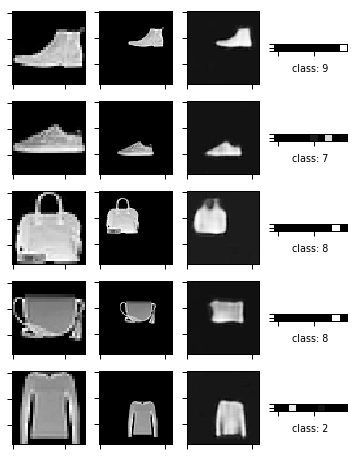

In [44]:
enc_dec_samples(DL.x_test,DL.sx_test,z_enc,y_lat,generator)

In [45]:
z_enc2 = z_encoder.predict(DL2.sx_test,batch_size=config.batch_size)
y_lat2 = classifier.predict(DL2.sx_test,batch_size=config.batch_size)
_lat_vec2 = np.concatenate([y_lat2,z_enc2],axis=1)
regen2 = generator.predict(_lat_vec2,batch_size=config.batch_size)

In [46]:
from src.plot import remove_axes,remove_labels
from src.utils import gen_trajectory

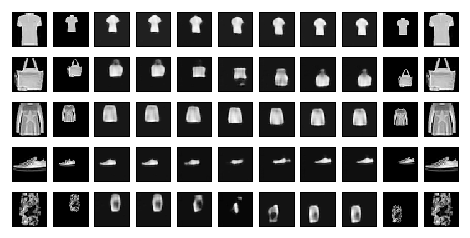

In [47]:
examples = 5
rand_im = np.random.randint(0,10000,size=examples)
fix,axs = plt.subplots(examples,11,figsize=(8,4))
_lat_s = []
regen_s = []
out = gen_trajectory(z_enc[rand_im],z_enc2[rand_im],delta=.25)
out_y = gen_trajectory(y_lat[rand_im],y_lat2[rand_im],delta=.25)

for z,y in zip(out,out_y):
    _lat = np.concatenate([y,z],axis=1)
    _lat_s.append(_lat)
    regen_s.append(generator.predict(_lat,batch_size=config.batch_size))

i=0
for axr,idx in zip(axs,rand_im):
    axr[0].imshow(DL.x_test[idx].reshape(28,28),cmap='gray')
    axr[1].imshow(DL.sx_test[idx].reshape(56,56),cmap='gray')
    axr[2].imshow(regen[idx].reshape(56,56),cmap='gray')
    for j,a in enumerate(axr[3:-3]):
        a.imshow(regen_s[j][i,:].reshape(56,56),cmap='gray')
#         a.imshow(s.reshape(56,56),cmap='gray')
    axr[-3].imshow(regen2[idx].reshape(56,56),cmap='gray')
    axr[-2].imshow(DL2.sx_test[idx].reshape(56,56),cmap='gray')
    axr[-1].imshow(DL2.x_test[idx].reshape(28,28),cmap='gray')
    for a in axr:
        remove_axes(a)
        remove_labels(a)
    i+=1
# plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [48]:
fix.savefig('../../updates/2019-02-05/assets/img/translocate_{}.png'.format(translation_amt))

In [49]:
dxs = DL.dx[1]-14
dys = DL.dy[1]-14

In [50]:
from sklearn.preprocessing import MinMaxScaler

feat_range = (0,50)
z_enc_scaled = [MinMaxScaler(feat_range).fit_transform(z_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(25)]
z_enc_scaled = np.squeeze(np.array(z_enc_scaled,dtype=int))

In [51]:
l2_enc_scaled = [MinMaxScaler(feat_range).fit_transform(l2_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(2000)]
l2_enc_scaled = np.squeeze(np.array(l2_enc_scaled,dtype=int))

In [52]:
l2_enc_scaled.shape

(2000, 10000)

In [53]:
from collections import Counter
import dit
from dit import Distribution

def mutual_information(X,Y):
    XY_c = Counter(zip(X,Y))
    XY_pmf = {k:v/float(sum(XY_c.values())) for k,v in XY_c.items()}
    XY_jdist = Distribution(XY_pmf)
        
    return dit.shannon.mutual_information(XY_jdist,[0],[1])

In [54]:
z_dx_I = [mutual_information(z_enc_scaled[i],dxs.astype(int)+14) for i in np.arange(25)]
l2_dx_I = [mutual_information(l2_enc_scaled[i],dxs.astype(int)+14) for i in np.arange(2000)]

In [55]:
z_dy_I = [mutual_information(z_enc_scaled[i],dys.astype(int)+14) for i in np.arange(25)]
l2_dy_I = [mutual_information(l2_enc_scaled[i],dys.astype(int)+14) for i in np.arange(2000)]

In [56]:
z_class_I = [mutual_information(z_enc_scaled[i],DL.y_test) for i in np.arange(25)]
l2_class_I = [mutual_information(l2_enc_scaled[i],DL.y_test) for i in np.arange(2000)]

In [57]:
z_I_df = pd.DataFrame.from_records({'class':z_class_I,'dy':z_dy_I,'dx':z_dx_I})
z_I_df['class'] = z_I_df['class'].values.round(decimals=1)

In [58]:
l2_I_df = pd.DataFrame.from_records({
    'class':l2_class_I,
    'dy':l2_dy_I,
    'dx':l2_dx_I})
l2_I_df['class'] = l2_I_df['class'].values.round(decimals=1)

In [59]:
l2_I_df.head()

,class,dx,dy
0,0.0,0.055606,0.054307
1,0.0,0.007297,0.007529
2,0.0,0.000000,0.000000
3,0.0,0.000441,0.000444
4,0.0,0.000000,0.000000


(array([1445.,  285.,  128.,   61.,   30.,   19.,   14.,    9.,    5.,
           4.]),
 array([0.        , 0.06578905, 0.13157811, 0.19736716, 0.26315622,
        0.32894527, 0.39473433, 0.46052338, 0.52631244, 0.59210149,
        0.65789055]),
 <a list of 10 Patch objects>)

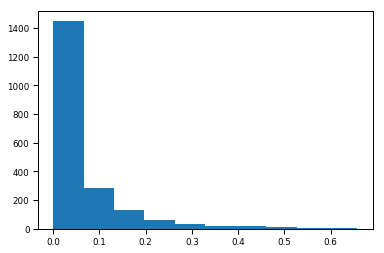

In [60]:
plt.hist(l2_I_df.dx)

(array([6., 6., 6., 2., 2., 0., 1., 1., 0., 1.]),
 array([0.10293949, 0.14581708, 0.18869466, 0.23157225, 0.27444984,
        0.31732743, 0.36020502, 0.4030826 , 0.44596019, 0.48883778,
        0.53171537]),
 <a list of 10 Patch objects>)

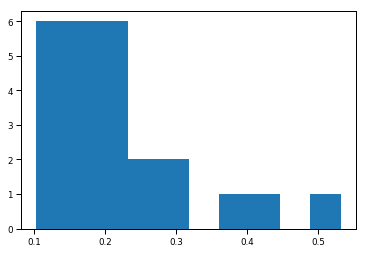

In [61]:
plt.hist(z_I_df.dx)

In [62]:
config.translation_amt = translation_amt
config.translation_amt

0.8

In [63]:
dir_path = '../data/xcov_importance/dist_{}/'.format(translation_amt)

z_I_df.to_pickle('../data/xcov_importance/dist_{}/z_mutual_info.pk'.format(translation_amt))
np.save('../data/xcov_importance/dist_{}/dxs'.format(translation_amt), DL.dx[1]-14)
np.save('../data/xcov_importance/dist_{}/dys'.format(translation_amt), DL.dy[1]-14)
np.save('../data/xcov_importance/dist_{}/z_enc'.format(translation_amt), z_enc)

hist_df.to_pickle(os.path.join(dir_path,'training_hist.df'))

with open(os.path.join(dir_path,'config.json'), 'w') as fp:
        json.dump(vars(config), fp)

FileNotFoundError: [Errno 2] No such file or directory: '../data/xcov_importance/dist_0.8/z_mutual_info.pk'

In [64]:
def filter_by_weight(wts,thresh=0.01):
    idxs = np.abs(wts)>thresh
    return idxs

In [65]:
dx_max = np.argmax(z_I_df.dx.values)
dy_max = np.argmax(z_I_df.dy.values)

num:  440
intersect_frac:  0.08409090909090909
mean dx_I:  0.07782638289859452
mean dy_I:  0.10531385018144805


(0, 0.9)

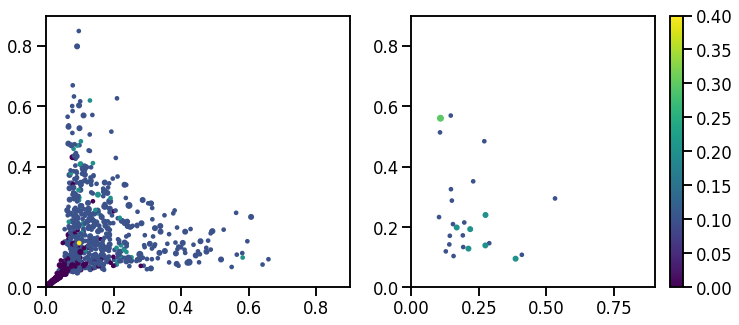

In [78]:
t = 0.05
dx_filt = filter_by_weight(z_w_k[:,dx_max],thresh=t)
dy_filt = filter_by_weight(z_w_k[:,dy_max],thresh=t)
union = np.union1d(np.where(dx_filt==True),np.where(dy_filt==True))
intersect = np.intersect1d(np.where(dx_filt==True),np.where(dy_filt==True))
# filt = np.array([False]*2000)
# filt[union] = True

sns.set_context('talk')
fig,axs = plt.subplots(1,2,figsize=(6*2,5))

filt = dy_filt
print('num: ',len(union))
print('intersect_frac: ',float(len(intersect))/len(union))
print('mean dx_I: ',l2_I_df.dx[filt].mean())
print('mean dy_I: ',l2_I_df.dy[filt].mean())
points = axs[0].scatter(x=l2_I_df['dx'],y=l2_I_df['dy'],
                        c=l2_I_df['class'],cmap='viridis',vmin=0,vmax=0.4,s=z_I_df['class']*100
                       )
plt.colorbar(points)
points = axs[1].scatter(x=z_I_df['dx'],y=z_I_df['dy'],c=z_I_df['class'],cmap='viridis',s=z_I_df['class']*100,vmin=0,vmax=0.4)
# plt.colorbar(points)
axs[0].set_ylim(0,0.9)
axs[0].set_xlim(0,0.9)
axs[1].set_ylim(0,0.9)
axs[1].set_xlim(0,0.9)


In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(z_dx_I,z_dy_I)
# ax.set_ylim(0,0.8)
# ax.set_xlim(0,0.8)

In [ ]:
plt.scatter(np.arange(25),sorted(z_class_I,reverse=True))
# plt.scatter(np.arange(25),z_dx_I)
# plt.scatter(np.arange(25),z_dy_I)

In [ ]:
from src.metrics import var_expl,norm_var_expl
from collections import Counter

dtheta = DL.dtheta[1]
fve_dx = norm_var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = norm_var_expl(features=z_enc,cond=dys,bins=21)
fve_class = norm_var_expl(features=z_enc, cond=DL.y_test, bins=21)
# fve_dt = norm_var_expl(features=z_enc,cond=dtheta,bins=21)

In [ ]:
# fve_dx_norm = (dxs.var()-fve_dx)/dxs.var()
# fve_dy_norm = (dys.var()-fve_dy)/dys.var()
# fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()
fve_dx_norm = fve_dx
fve_dy_norm = fve_dy

In [ ]:
import seaborn as sns
sns.set_context('talk')

In [ ]:
fve_dx_norm.shape
# np.save(os.path.join(config.model_dir,'fve_dx_norm'),fve_dx_norm)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
plt.scatter(fve_dx_norm.mean(axis=0),fve_dy_norm.mean(axis=0))
plt.xlabel('fve_dx')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dx.png'))
# plt.ylim(-0.125,0.25)
xdim = np.argmax(fve_dx_norm.mean(axis=0))

In [ ]:
fve_dy_norm.mean(axis=0)
# np.save(os.path.join(config.model_dir,'fve_dy_norm'),fve_dy_norm)

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dy.png'))
# plt.ylim(-0.125,0.25)
ydim = np.argmax(fve_dy_norm.mean(axis=0))

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_class.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_class')
# plt.ylim(0.0,0.5)
np.argmax(fve_class.mean(axis=0))

In [ ]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[xdim,ydim],dxs)

In [ ]:
Z_color_scatter(z_enc,[xdim,ydim],dys)

In [ ]:
Z_color_scatter(z_enc,[7,18],dtheta)

In [ ]:
from plt.